In [1]:
# from https://www.kaggle.com/rejpalcz/gapnet-pl-lb-0-385
import sys
import numpy as np
import keras
from keras.utils import Sequence
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
# import imgaug as ia
# from imgaug import augmenters as iaa
import cv2

Using TensorFlow backend.


In [2]:
BATCH_SIZE = 64
SEED = 777
SHAPE = (512, 512, 4)
DIR = '../'
VAL_RATIO = 0.1 # 10 % as validation
THRESHOLD = 0.5 # due to different cost of True Positive vs False Positive, this is the probability threshold to predict the class as 'yes'

# ia.seed(SEED)

def getTrainDataset():
    
    path_to_train = DIR + 'train/'
    data = pd.read_csv(DIR + 'train.csv')

    paths = []
    labels = []
    
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(28)
        for key in lbl:
            y[int(key)] = 1
        paths.append(os.path.join(path_to_train, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

def getTestDataset():
    
    path_to_test = DIR + 'test/'
    data = pd.read_csv(DIR + 'sample_submission.csv')

    paths = []
    labels = []
    
    for name in data['Id']:
        y = np.ones(28)
        paths.append(os.path.join(path_to_test, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

In [3]:
# credits: https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py#L302
# credits: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class ProteinDataGenerator(keras.utils.Sequence):
            
    def __init__(self, paths, labels, batch_size, shape, shuffle = False, use_cache = False, augment = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.augment = augment
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]), dtype=np.float16)
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)

        y = self.labels[indexes]
        
        if self.augment == True:
            """
            seq = iaa.Sequential([
            iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    iaa.Crop(percent=(0, 0.1)), # random crops
                    # Small gaussian blur with random sigma between 0 and 0.5.
                    # But we only blur about 50% of all images.
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    # Strengthen or weaken the contrast in each image.
                    iaa.ContrastNormalization((0.75, 1.5)),
                    # Add gaussian noise.
                    # For 50% of all images, we sample the noise once per pixel.
                    # For the other 50% of all images, we sample the noise per pixel AND
                    # channel. This can change the color (not only brightness) of the
                    # pixels.
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    # Make some images brighter and some darker.
                    # In 20% of all cases, we sample the multiplier once per channel,
                    # which can end up changing the color of the images.
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    # Apply affine transformations to each image.
                    # Scale/zoom them, translate/move them, rotate them and shear them.
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])], random_order=True)
            
            X = np.concatenate((X, seq.augment_images(X), seq.augment_images(X), seq.augment_images(X)), 0)
            y = np.concatenate((y, y, y, y), 0)
            """
        return X, y
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        R = Image.open(path + '_red.png')
        G = Image.open(path + '_green.png')
        B = Image.open(path + '_blue.png')
        Y = Image.open(path + '_yellow.png')

        im = np.stack((
            np.array(R), 
            np.array(G), 
            np.array(B),
            np.array(Y)), -1)
        
        im = cv2.resize(im, (SHAPE[0], SHAPE[1]))
        im = np.divide(im, 255)
        if self.augment:
            if random.randint(0, 1):
                im = im[:, ::-1, :]
            if random.randint(0, 1):
                im = im[::-1, :, :]
        return im

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, ReLU, LeakyReLU, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import metrics
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import keras
import tensorflow as tf

from tensorflow import set_random_seed
set_random_seed(SEED)


In [5]:
# credits: https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras

def f1(y_true, y_pred):
    #y_pred = K.round(y_pred)
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

In [6]:
from keras.activations import elu

def selu(x):
    """Scaled Exponential Linear Unit. (Klambauer et al., 2017)
    # Arguments
        x: A tensor or variable to compute the activation function for.
    # References
        - [Self-Normalizing Neural Networks](https://arxiv.org/abs/1706.02515)
    """
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * elu(x, alpha)

In [7]:
from keras.layers.core import Lambda
from keras import regularizers
def create_model(input_shape):
    
    init = Input(input_shape)
    x = BatchNormalization(axis=-1)(init)
    x = Conv2D(32, (3, 3),strides=(2,2), kernel_regularizer=regularizers.l2(1e-5),
               activity_regularizer=regularizers.l1(1e-7))(x)
    x = Lambda(lambda x:selu(x))(x)
    
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    gap1=GlobalAveragePooling2D()(x)
    
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(64, (3, 3), strides=(2,2), kernel_regularizer=regularizers.l2(1e-5),
               activity_regularizer=regularizers.l1(1e-7))(x)
    x = Lambda(lambda x:selu(x))(x)
    
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(64, (3, 3), strides=(1,1), kernel_regularizer=regularizers.l2(1e-5),
               activity_regularizer=regularizers.l1(1e-7))(x)
    x = Lambda(lambda x:selu(x))(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(64, (3, 3), strides=(1,1), kernel_regularizer=regularizers.l2(1e-5),
               activity_regularizer=regularizers.l1(1e-7))(x)
    x = Lambda(lambda x:selu(x))(x)
    
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    gap2=GlobalAveragePooling2D()(x)
    
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(128, (3, 3),strides=(1,1), kernel_regularizer=regularizers.l2(1e-5),
               activity_regularizer=regularizers.l1(1e-7))(x)
    x = Lambda(lambda x:selu(x))(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(128, (3, 3),strides=(1,1), kernel_regularizer=regularizers.l2(1e-5),
               activity_regularizer=regularizers.l1(1e-7))(x)
    x = Lambda(lambda x:selu(x))(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(128, (3, 3),strides=(1,1), kernel_regularizer=regularizers.l2(1e-5),
               activity_regularizer=regularizers.l1(1e-7))(x)
    x = Lambda(lambda x:selu(x))(x)
    
    gap3=GlobalAveragePooling2D()(x)
    
    x = Concatenate()([gap1, gap2, gap3])
    
    x = BatchNormalization(axis=-1)(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-5),
               activity_regularizer=regularizers.l1(1e-7))(x)
    x = Dropout(0.3)(x)
    
    x = BatchNormalization(axis=-1)(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-5),
               activity_regularizer=regularizers.l1(1e-7))(x)
    x = Dropout(0.3)(x)
    
    x = Dense(28, kernel_regularizer=regularizers.l2(1e-5),
               activity_regularizer=regularizers.l1(1e-7))(x)
    x = Activation('sigmoid')(x)
    
    model = Model(init, x)
    
    return model
    
    
    
    

In [8]:
from keras.optimizers import SGD

model = create_model(SHAPE)
model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=0.01,momentum=0.9,clipvalue=5.),    # need gradient clipping ??
    metrics=['acc',f1])

"""
To avoid overfitting the following regularization techniques
are applied: L1 norm of 1e−7, L2 norm of 1e−5.
↑???
"""
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 4)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 4)  16          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 255, 255, 32) 1184        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 255, 255, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________


In [9]:
paths, labels = getTrainDataset()

# divide to 
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

pathsTrain = paths[0:lastTrainIndex]
labelsTrain = labels[0:lastTrainIndex]
pathsVal = paths[lastTrainIndex:]
labelsVal = labels[lastTrainIndex:]

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)

tg = ProteinDataGenerator(pathsTrain, labelsTrain, BATCH_SIZE, SHAPE, use_cache=False, augment = False, shuffle = False)
vg = ProteinDataGenerator(pathsVal, labelsVal, BATCH_SIZE, SHAPE, use_cache=False, shuffle = False)

# https://keras.io/callbacks/#modelcheckpoint
checkpoint = ModelCheckpoint('./base.model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')

(31072,) (31072, 28)
(27964,) (27964, 28) (3108,) (3108, 28)


In [10]:
epochs = 8

use_multiprocessing = False # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 
workers = 1 # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 

hist = model.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    validation_steps=8,
    epochs=epochs,
    use_multiprocessing=use_multiprocessing,
    workers=workers,
    verbose=1,
    callbacks=[checkpoint])

Epoch 1/8


157/437 [=========>....................] - ETA: 34:37 - loss: 8.4050 - acc: 0.5162 - f1: 0.085 - ETA: 19:41 - loss: 8.3853 - acc: 0.5153 - f1: 0.086 - ETA: 14:38 - loss: 8.1817 - acc: 0.5193 - f1: 0.087 - ETA: 12:08 - loss: 7.9330 - acc: 0.5279 - f1: 0.086 - ETA: 10:39 - loss: 7.7248 - acc: 0.5314 - f1: 0.084 - ETA: 9:39 - loss: 7.5461 - acc: 0.5344 - f1: 0.086 - ETA: 8:56 - loss: 7.3843 - acc: 0.5441 - f1: 0.08 - ETA: 8:24 - loss: 7.2412 - acc: 0.5513 - f1: 0.08 - ETA: 8:19 - loss: 7.1003 - acc: 0.5575 - f1: 0.08 - ETA: 8:15 - loss: 6.9734 - acc: 0.5652 - f1: 0.08 - ETA: 8:11 - loss: 6.8714 - acc: 0.5705 - f1: 0.08 - ETA: 8:02 - loss: 6.7382 - acc: 0.5769 - f1: 0.08 - ETA: 7:57 - loss: 6.6383 - acc: 0.5837 - f1: 0.08 - ETA: 7:50 - loss: 6.5252 - acc: 0.5908 - f1: 0.08 - ETA: 7:45 - loss: 6.4339 - acc: 0.5974 - f1: 0.08 - ETA: 7:40 - loss: 6.3421 - acc: 0.6045 - f1: 0.08 - ETA: 7:35 - loss: 6.2480 - acc: 0.6102 - f1: 0.08 - ETA: 7:31 - loss: 6.1648 - acc: 0.6167 - f1: 0.08 - ETA: 7:27 

314/437 [====================>.........] - ETA: 5:47 - loss: 3.0167 - acc: 0.8841 - f1: 0.07 - ETA: 5:45 - loss: 3.0110 - acc: 0.8845 - f1: 0.07 - ETA: 5:44 - loss: 3.0049 - acc: 0.8848 - f1: 0.07 - ETA: 5:42 - loss: 2.9987 - acc: 0.8851 - f1: 0.07 - ETA: 5:40 - loss: 2.9925 - acc: 0.8854 - f1: 0.07 - ETA: 5:38 - loss: 2.9865 - acc: 0.8857 - f1: 0.07 - ETA: 5:37 - loss: 2.9806 - acc: 0.8860 - f1: 0.07 - ETA: 5:35 - loss: 2.9747 - acc: 0.8863 - f1: 0.07 - ETA: 5:33 - loss: 2.9687 - acc: 0.8866 - f1: 0.07 - ETA: 5:32 - loss: 2.9627 - acc: 0.8870 - f1: 0.07 - ETA: 5:30 - loss: 2.9566 - acc: 0.8873 - f1: 0.07 - ETA: 5:28 - loss: 2.9506 - acc: 0.8876 - f1: 0.07 - ETA: 5:27 - loss: 2.9446 - acc: 0.8879 - f1: 0.07 - ETA: 5:25 - loss: 2.9392 - acc: 0.8882 - f1: 0.07 - ETA: 5:23 - loss: 2.9335 - acc: 0.8885 - f1: 0.07 - ETA: 5:27 - loss: 2.9280 - acc: 0.8888 - f1: 0.07 - ETA: 5:25 - loss: 2.9223 - acc: 0.8891 - f1: 0.07 - ETA: 5:24 - loss: 2.9162 - acc: 0.8894 - f1: 0.07 - ETA: 5:22 - loss: 2.9

437/437 [==============================] - ETA: 2:33 - loss: 2.4503 - acc: 0.9107 - f1: 0.06 - ETA: 2:32 - loss: 2.4475 - acc: 0.9108 - f1: 0.06 - ETA: 2:31 - loss: 2.4448 - acc: 0.9108 - f1: 0.06 - ETA: 2:29 - loss: 2.4422 - acc: 0.9109 - f1: 0.06 - ETA: 2:28 - loss: 2.4396 - acc: 0.9110 - f1: 0.06 - ETA: 2:26 - loss: 2.4370 - acc: 0.9111 - f1: 0.06 - ETA: 2:25 - loss: 2.4344 - acc: 0.9112 - f1: 0.06 - ETA: 2:24 - loss: 2.4318 - acc: 0.9113 - f1: 0.06 - ETA: 2:22 - loss: 2.4292 - acc: 0.9114 - f1: 0.06 - ETA: 2:21 - loss: 2.4267 - acc: 0.9114 - f1: 0.06 - ETA: 2:20 - loss: 2.4243 - acc: 0.9115 - f1: 0.06 - ETA: 2:18 - loss: 2.4221 - acc: 0.9116 - f1: 0.06 - ETA: 2:17 - loss: 2.4195 - acc: 0.9117 - f1: 0.06 - ETA: 2:16 - loss: 2.4171 - acc: 0.9118 - f1: 0.06 - ETA: 2:14 - loss: 2.4143 - acc: 0.9118 - f1: 0.06 - ETA: 2:13 - loss: 2.4116 - acc: 0.9119 - f1: 0.06 - ETA: 2:12 - loss: 2.4093 - acc: 0.9120 - f1: 0.06 - ETA: 2:10 - loss: 2.4074 - acc: 0.9121 - f1: 0.06 - ETA: 2:10 - loss: 2.4

157/437 [=========>....................] - ETA: 4:52 - loss: 1.6058 - acc: 0.9302 - f1: 0.05 - ETA: 4:52 - loss: 1.5735 - acc: 0.9325 - f1: 0.05 - ETA: 4:47 - loss: 1.5418 - acc: 0.9336 - f1: 0.05 - ETA: 4:44 - loss: 1.5121 - acc: 0.9351 - f1: 0.05 - ETA: 4:45 - loss: 1.5091 - acc: 0.9358 - f1: 0.05 - ETA: 4:45 - loss: 1.4963 - acc: 0.9359 - f1: 0.05 - ETA: 4:46 - loss: 1.4992 - acc: 0.9354 - f1: 0.05 - ETA: 4:46 - loss: 1.5020 - acc: 0.9362 - f1: 0.05 - ETA: 4:46 - loss: 1.5054 - acc: 0.9362 - f1: 0.05 - ETA: 4:46 - loss: 1.5257 - acc: 0.9360 - f1: 0.05 - ETA: 4:46 - loss: 1.5438 - acc: 0.9364 - f1: 0.05 - ETA: 4:45 - loss: 1.5563 - acc: 0.9367 - f1: 0.05 - ETA: 4:44 - loss: 1.5594 - acc: 0.9372 - f1: 0.05 - ETA: 4:43 - loss: 1.5630 - acc: 0.9376 - f1: 0.05 - ETA: 4:41 - loss: 1.5684 - acc: 0.9379 - f1: 0.05 - ETA: 4:40 - loss: 1.5767 - acc: 0.9380 - f1: 0.05 - ETA: 4:39 - loss: 1.5787 - acc: 0.9383 - f1: 0.05 - ETA: 4:38 - loss: 1.5750 - acc: 0.9383 - f1: 0.05 - ETA: 4:36 - loss: 1.5

314/437 [====================>.........] - ETA: 4:16 - loss: 1.5165 - acc: 0.9387 - f1: 0.05 - ETA: 4:15 - loss: 1.5154 - acc: 0.9387 - f1: 0.05 - ETA: 4:14 - loss: 1.5166 - acc: 0.9387 - f1: 0.05 - ETA: 4:13 - loss: 1.5171 - acc: 0.9387 - f1: 0.05 - ETA: 4:12 - loss: 1.5163 - acc: 0.9387 - f1: 0.05 - ETA: 4:11 - loss: 1.5163 - acc: 0.9387 - f1: 0.05 - ETA: 4:11 - loss: 1.5160 - acc: 0.9387 - f1: 0.05 - ETA: 4:10 - loss: 1.5152 - acc: 0.9387 - f1: 0.05 - ETA: 4:09 - loss: 1.5132 - acc: 0.9388 - f1: 0.05 - ETA: 4:08 - loss: 1.5127 - acc: 0.9388 - f1: 0.05 - ETA: 4:07 - loss: 1.5116 - acc: 0.9387 - f1: 0.05 - ETA: 4:07 - loss: 1.5100 - acc: 0.9387 - f1: 0.05 - ETA: 4:06 - loss: 1.5081 - acc: 0.9388 - f1: 0.05 - ETA: 4:05 - loss: 1.5070 - acc: 0.9388 - f1: 0.05 - ETA: 4:04 - loss: 1.5067 - acc: 0.9388 - f1: 0.05 - ETA: 4:03 - loss: 1.5063 - acc: 0.9388 - f1: 0.05 - ETA: 4:03 - loss: 1.5060 - acc: 0.9388 - f1: 0.05 - ETA: 4:03 - loss: 1.5050 - acc: 0.9388 - f1: 0.05 - ETA: 4:02 - loss: 1.5

437/437 [==============================] - ETA: 1:55 - loss: 1.3855 - acc: 0.9388 - f1: 0.05 - ETA: 1:54 - loss: 1.3843 - acc: 0.9388 - f1: 0.05 - ETA: 1:53 - loss: 1.3831 - acc: 0.9388 - f1: 0.05 - ETA: 1:52 - loss: 1.3816 - acc: 0.9388 - f1: 0.05 - ETA: 1:51 - loss: 1.3801 - acc: 0.9388 - f1: 0.05 - ETA: 1:50 - loss: 1.3790 - acc: 0.9388 - f1: 0.05 - ETA: 1:49 - loss: 1.3781 - acc: 0.9388 - f1: 0.05 - ETA: 1:48 - loss: 1.3771 - acc: 0.9388 - f1: 0.05 - ETA: 1:47 - loss: 1.3761 - acc: 0.9388 - f1: 0.05 - ETA: 1:46 - loss: 1.3749 - acc: 0.9388 - f1: 0.05 - ETA: 1:45 - loss: 1.3738 - acc: 0.9388 - f1: 0.05 - ETA: 1:44 - loss: 1.3725 - acc: 0.9388 - f1: 0.05 - ETA: 1:43 - loss: 1.3712 - acc: 0.9388 - f1: 0.05 - ETA: 1:42 - loss: 1.3700 - acc: 0.9388 - f1: 0.05 - ETA: 1:42 - loss: 1.3686 - acc: 0.9388 - f1: 0.05 - ETA: 1:41 - loss: 1.3671 - acc: 0.9388 - f1: 0.05 - ETA: 1:40 - loss: 1.3656 - acc: 0.9388 - f1: 0.05 - ETA: 1:39 - loss: 1.3641 - acc: 0.9388 - f1: 0.05 - ETA: 1:38 - loss: 1.3

157/437 [=========>....................] - ETA: 4:35 - loss: 0.9488 - acc: 0.9353 - f1: 0.06 - ETA: 4:42 - loss: 0.9348 - acc: 0.9375 - f1: 0.06 - ETA: 4:41 - loss: 0.9270 - acc: 0.9384 - f1: 0.06 - ETA: 4:45 - loss: 0.9086 - acc: 0.9389 - f1: 0.06 - ETA: 4:43 - loss: 0.9137 - acc: 0.9382 - f1: 0.06 - ETA: 4:41 - loss: 0.9157 - acc: 0.9391 - f1: 0.06 - ETA: 4:40 - loss: 0.9142 - acc: 0.9404 - f1: 0.05 - ETA: 4:39 - loss: 0.9198 - acc: 0.9404 - f1: 0.05 - ETA: 4:37 - loss: 0.9250 - acc: 0.9402 - f1: 0.05 - ETA: 4:36 - loss: 0.9298 - acc: 0.9408 - f1: 0.05 - ETA: 4:35 - loss: 0.9377 - acc: 0.9406 - f1: 0.05 - ETA: 4:35 - loss: 0.9413 - acc: 0.9402 - f1: 0.05 - ETA: 4:35 - loss: 0.9444 - acc: 0.9399 - f1: 0.05 - ETA: 4:33 - loss: 0.9486 - acc: 0.9400 - f1: 0.05 - ETA: 4:33 - loss: 0.9601 - acc: 0.9398 - f1: 0.05 - ETA: 4:33 - loss: 0.9704 - acc: 0.9399 - f1: 0.05 - ETA: 4:32 - loss: 0.9801 - acc: 0.9398 - f1: 0.05 - ETA: 4:31 - loss: 0.9871 - acc: 0.9400 - f1: 0.05 - ETA: 4:31 - loss: 0.9

314/437 [====================>.........] - ETA: 4:11 - loss: 0.8746 - acc: 0.9396 - f1: 0.05 - ETA: 4:11 - loss: 0.8761 - acc: 0.9396 - f1: 0.05 - ETA: 4:10 - loss: 0.8771 - acc: 0.9396 - f1: 0.05 - ETA: 4:09 - loss: 0.8783 - acc: 0.9396 - f1: 0.05 - ETA: 4:08 - loss: 0.8793 - acc: 0.9396 - f1: 0.05 - ETA: 4:07 - loss: 0.8802 - acc: 0.9396 - f1: 0.05 - ETA: 4:06 - loss: 0.8808 - acc: 0.9396 - f1: 0.05 - ETA: 4:06 - loss: 0.8807 - acc: 0.9396 - f1: 0.05 - ETA: 4:05 - loss: 0.8807 - acc: 0.9396 - f1: 0.05 - ETA: 4:04 - loss: 0.8805 - acc: 0.9397 - f1: 0.05 - ETA: 4:03 - loss: 0.8798 - acc: 0.9396 - f1: 0.05 - ETA: 4:02 - loss: 0.8789 - acc: 0.9397 - f1: 0.05 - ETA: 4:01 - loss: 0.8779 - acc: 0.9397 - f1: 0.05 - ETA: 4:01 - loss: 0.8786 - acc: 0.9397 - f1: 0.05 - ETA: 4:00 - loss: 0.8787 - acc: 0.9397 - f1: 0.05 - ETA: 3:59 - loss: 0.8789 - acc: 0.9397 - f1: 0.05 - ETA: 3:58 - loss: 0.8788 - acc: 0.9397 - f1: 0.05 - ETA: 3:57 - loss: 0.8792 - acc: 0.9397 - f1: 0.05 - ETA: 3:56 - loss: 0.8

437/437 [==============================] - ETA: 1:53 - loss: 0.8419 - acc: 0.9396 - f1: 0.05 - ETA: 1:52 - loss: 0.8413 - acc: 0.9396 - f1: 0.05 - ETA: 1:51 - loss: 0.8408 - acc: 0.9396 - f1: 0.05 - ETA: 1:50 - loss: 0.8402 - acc: 0.9396 - f1: 0.05 - ETA: 1:49 - loss: 0.8396 - acc: 0.9396 - f1: 0.05 - ETA: 1:48 - loss: 0.8391 - acc: 0.9396 - f1: 0.05 - ETA: 1:47 - loss: 0.8383 - acc: 0.9396 - f1: 0.05 - ETA: 1:46 - loss: 0.8375 - acc: 0.9396 - f1: 0.05 - ETA: 1:45 - loss: 0.8369 - acc: 0.9396 - f1: 0.05 - ETA: 1:44 - loss: 0.8363 - acc: 0.9396 - f1: 0.05 - ETA: 1:43 - loss: 0.8356 - acc: 0.9396 - f1: 0.05 - ETA: 1:43 - loss: 0.8349 - acc: 0.9396 - f1: 0.05 - ETA: 1:42 - loss: 0.8341 - acc: 0.9396 - f1: 0.05 - ETA: 1:41 - loss: 0.8332 - acc: 0.9397 - f1: 0.05 - ETA: 1:40 - loss: 0.8323 - acc: 0.9397 - f1: 0.05 - ETA: 1:39 - loss: 0.8317 - acc: 0.9397 - f1: 0.06 - ETA: 1:38 - loss: 0.8310 - acc: 0.9397 - f1: 0.06 - ETA: 1:37 - loss: 0.8305 - acc: 0.9397 - f1: 0.05 - ETA: 1:36 - loss: 0.8

157/437 [=========>....................] - ETA: 4:39 - loss: 0.6108 - acc: 0.9420 - f1: 0.06 - ETA: 4:38 - loss: 0.6178 - acc: 0.9397 - f1: 0.06 - ETA: 4:38 - loss: 0.6046 - acc: 0.9412 - f1: 0.06 - ETA: 4:37 - loss: 0.5983 - acc: 0.9410 - f1: 0.06 - ETA: 4:36 - loss: 0.6045 - acc: 0.9406 - f1: 0.06 - ETA: 4:36 - loss: 0.6106 - acc: 0.9409 - f1: 0.06 - ETA: 4:35 - loss: 0.6093 - acc: 0.9415 - f1: 0.06 - ETA: 4:35 - loss: 0.6124 - acc: 0.9411 - f1: 0.06 - ETA: 4:35 - loss: 0.6133 - acc: 0.9416 - f1: 0.06 - ETA: 4:34 - loss: 0.6135 - acc: 0.9411 - f1: 0.06 - ETA: 4:33 - loss: 0.6092 - acc: 0.9410 - f1: 0.06 - ETA: 4:32 - loss: 0.6040 - acc: 0.9411 - f1: 0.06 - ETA: 4:32 - loss: 0.5949 - acc: 0.9410 - f1: 0.06 - ETA: 4:31 - loss: 0.5904 - acc: 0.9411 - f1: 0.06 - ETA: 4:30 - loss: 0.5869 - acc: 0.9414 - f1: 0.06 - ETA: 4:30 - loss: 0.5835 - acc: 0.9412 - f1: 0.06 - ETA: 4:29 - loss: 0.5808 - acc: 0.9410 - f1: 0.06 - ETA: 4:29 - loss: 0.5773 - acc: 0.9411 - f1: 0.06 - ETA: 4:28 - loss: 0.5

314/437 [====================>.........] - ETA: 4:09 - loss: 0.6253 - acc: 0.9415 - f1: 0.06 - ETA: 4:08 - loss: 0.6254 - acc: 0.9415 - f1: 0.06 - ETA: 4:08 - loss: 0.6255 - acc: 0.9415 - f1: 0.06 - ETA: 4:07 - loss: 0.6255 - acc: 0.9415 - f1: 0.06 - ETA: 4:06 - loss: 0.6257 - acc: 0.9414 - f1: 0.06 - ETA: 4:05 - loss: 0.6256 - acc: 0.9415 - f1: 0.06 - ETA: 4:04 - loss: 0.6254 - acc: 0.9415 - f1: 0.06 - ETA: 4:04 - loss: 0.6253 - acc: 0.9415 - f1: 0.06 - ETA: 4:03 - loss: 0.6251 - acc: 0.9415 - f1: 0.06 - ETA: 4:02 - loss: 0.6252 - acc: 0.9415 - f1: 0.06 - ETA: 4:01 - loss: 0.6253 - acc: 0.9415 - f1: 0.06 - ETA: 4:00 - loss: 0.6257 - acc: 0.9414 - f1: 0.06 - ETA: 3:59 - loss: 0.6261 - acc: 0.9414 - f1: 0.06 - ETA: 3:59 - loss: 0.6264 - acc: 0.9414 - f1: 0.06 - ETA: 3:58 - loss: 0.6266 - acc: 0.9414 - f1: 0.06 - ETA: 3:57 - loss: 0.6266 - acc: 0.9414 - f1: 0.06 - ETA: 3:56 - loss: 0.6266 - acc: 0.9414 - f1: 0.06 - ETA: 3:55 - loss: 0.6264 - acc: 0.9414 - f1: 0.06 - ETA: 3:54 - loss: 0.6

437/437 [==============================] - ETA: 1:52 - loss: 0.6149 - acc: 0.9411 - f1: 0.06 - ETA: 1:51 - loss: 0.6148 - acc: 0.9411 - f1: 0.06 - ETA: 1:50 - loss: 0.6145 - acc: 0.9411 - f1: 0.06 - ETA: 1:49 - loss: 0.6142 - acc: 0.9411 - f1: 0.06 - ETA: 1:48 - loss: 0.6139 - acc: 0.9411 - f1: 0.06 - ETA: 1:47 - loss: 0.6136 - acc: 0.9411 - f1: 0.06 - ETA: 1:46 - loss: 0.6137 - acc: 0.9411 - f1: 0.06 - ETA: 1:45 - loss: 0.6136 - acc: 0.9411 - f1: 0.06 - ETA: 1:44 - loss: 0.6136 - acc: 0.9411 - f1: 0.06 - ETA: 1:44 - loss: 0.6136 - acc: 0.9411 - f1: 0.06 - ETA: 1:43 - loss: 0.6136 - acc: 0.9411 - f1: 0.06 - ETA: 1:42 - loss: 0.6137 - acc: 0.9411 - f1: 0.06 - ETA: 1:41 - loss: 0.6136 - acc: 0.9411 - f1: 0.06 - ETA: 1:40 - loss: 0.6136 - acc: 0.9411 - f1: 0.06 - ETA: 1:39 - loss: 0.6134 - acc: 0.9411 - f1: 0.06 - ETA: 1:38 - loss: 0.6131 - acc: 0.9411 - f1: 0.06 - ETA: 1:37 - loss: 0.6129 - acc: 0.9411 - f1: 0.06 - ETA: 1:36 - loss: 0.6126 - acc: 0.9410 - f1: 0.06 - ETA: 1:35 - loss: 0.6

157/437 [=========>....................] - ETA: 4:40 - loss: 0.7294 - acc: 0.9330 - f1: 0.05 - ETA: 4:38 - loss: 0.7172 - acc: 0.9369 - f1: 0.06 - ETA: 4:40 - loss: 0.7326 - acc: 0.9382 - f1: 0.06 - ETA: 4:39 - loss: 0.7297 - acc: 0.9388 - f1: 0.06 - ETA: 4:39 - loss: 0.7233 - acc: 0.9393 - f1: 0.06 - ETA: 4:38 - loss: 0.7182 - acc: 0.9388 - f1: 0.06 - ETA: 4:37 - loss: 0.7128 - acc: 0.9389 - f1: 0.06 - ETA: 4:37 - loss: 0.7062 - acc: 0.9391 - f1: 0.06 - ETA: 4:36 - loss: 0.7014 - acc: 0.9392 - f1: 0.06 - ETA: 4:36 - loss: 0.6943 - acc: 0.9388 - f1: 0.06 - ETA: 4:35 - loss: 0.6878 - acc: 0.9390 - f1: 0.06 - ETA: 4:34 - loss: 0.6809 - acc: 0.9395 - f1: 0.06 - ETA: 4:34 - loss: 0.6764 - acc: 0.9387 - f1: 0.06 - ETA: 4:33 - loss: 0.6700 - acc: 0.9387 - f1: 0.06 - ETA: 4:32 - loss: 0.6625 - acc: 0.9389 - f1: 0.06 - ETA: 4:32 - loss: 0.6553 - acc: 0.9389 - f1: 0.06 - ETA: 4:31 - loss: 0.6498 - acc: 0.9394 - f1: 0.06 - ETA: 4:30 - loss: 0.6450 - acc: 0.9396 - f1: 0.06 - ETA: 4:29 - loss: 0.6

314/437 [====================>.........] - ETA: 4:11 - loss: 0.5504 - acc: 0.9412 - f1: 0.06 - ETA: 4:10 - loss: 0.5505 - acc: 0.9412 - f1: 0.06 - ETA: 4:09 - loss: 0.5505 - acc: 0.9412 - f1: 0.06 - ETA: 4:09 - loss: 0.5506 - acc: 0.9411 - f1: 0.06 - ETA: 4:08 - loss: 0.5506 - acc: 0.9411 - f1: 0.06 - ETA: 4:07 - loss: 0.5506 - acc: 0.9410 - f1: 0.06 - ETA: 4:06 - loss: 0.5505 - acc: 0.9410 - f1: 0.06 - ETA: 4:05 - loss: 0.5501 - acc: 0.9411 - f1: 0.06 - ETA: 4:04 - loss: 0.5500 - acc: 0.9410 - f1: 0.06 - ETA: 4:04 - loss: 0.5506 - acc: 0.9410 - f1: 0.06 - ETA: 4:03 - loss: 0.5513 - acc: 0.9410 - f1: 0.06 - ETA: 4:02 - loss: 0.5518 - acc: 0.9410 - f1: 0.06 - ETA: 4:01 - loss: 0.5524 - acc: 0.9410 - f1: 0.06 - ETA: 4:00 - loss: 0.5528 - acc: 0.9409 - f1: 0.06 - ETA: 3:59 - loss: 0.5534 - acc: 0.9409 - f1: 0.06 - ETA: 3:59 - loss: 0.5538 - acc: 0.9409 - f1: 0.06 - ETA: 3:58 - loss: 0.5543 - acc: 0.9409 - f1: 0.06 - ETA: 3:57 - loss: 0.5549 - acc: 0.9409 - f1: 0.06 - ETA: 3:56 - loss: 0.5

437/437 [==============================] - ETA: 1:53 - loss: 0.5473 - acc: 0.9405 - f1: 0.06 - ETA: 1:52 - loss: 0.5470 - acc: 0.9405 - f1: 0.06 - ETA: 1:51 - loss: 0.5467 - acc: 0.9405 - f1: 0.06 - ETA: 1:50 - loss: 0.5464 - acc: 0.9405 - f1: 0.06 - ETA: 1:49 - loss: 0.5460 - acc: 0.9405 - f1: 0.06 - ETA: 1:48 - loss: 0.5457 - acc: 0.9405 - f1: 0.06 - ETA: 1:48 - loss: 0.5453 - acc: 0.9405 - f1: 0.06 - ETA: 1:47 - loss: 0.5450 - acc: 0.9405 - f1: 0.06 - ETA: 1:46 - loss: 0.5446 - acc: 0.9405 - f1: 0.06 - ETA: 1:45 - loss: 0.5444 - acc: 0.9405 - f1: 0.06 - ETA: 1:44 - loss: 0.5442 - acc: 0.9405 - f1: 0.06 - ETA: 1:43 - loss: 0.5441 - acc: 0.9405 - f1: 0.06 - ETA: 1:42 - loss: 0.5441 - acc: 0.9405 - f1: 0.06 - ETA: 1:41 - loss: 0.5442 - acc: 0.9405 - f1: 0.06 - ETA: 1:40 - loss: 0.5442 - acc: 0.9405 - f1: 0.06 - ETA: 1:39 - loss: 0.5442 - acc: 0.9405 - f1: 0.06 - ETA: 1:38 - loss: 0.5443 - acc: 0.9405 - f1: 0.06 - ETA: 1:37 - loss: 0.5444 - acc: 0.9405 - f1: 0.06 - ETA: 1:36 - loss: 0.5

157/437 [=========>....................] - ETA: 4:40 - loss: 0.4621 - acc: 0.9392 - f1: 0.06 - ETA: 4:41 - loss: 0.4879 - acc: 0.9397 - f1: 0.05 - ETA: 4:41 - loss: 0.5064 - acc: 0.9377 - f1: 0.06 - ETA: 4:41 - loss: 0.5101 - acc: 0.9383 - f1: 0.05 - ETA: 4:40 - loss: 0.5090 - acc: 0.9395 - f1: 0.05 - ETA: 4:39 - loss: 0.5128 - acc: 0.9402 - f1: 0.05 - ETA: 4:40 - loss: 0.5154 - acc: 0.9408 - f1: 0.05 - ETA: 4:39 - loss: 0.5153 - acc: 0.9409 - f1: 0.05 - ETA: 4:39 - loss: 0.5160 - acc: 0.9400 - f1: 0.05 - ETA: 4:38 - loss: 0.5128 - acc: 0.9401 - f1: 0.05 - ETA: 4:38 - loss: 0.5094 - acc: 0.9403 - f1: 0.05 - ETA: 4:37 - loss: 0.5065 - acc: 0.9404 - f1: 0.05 - ETA: 4:37 - loss: 0.5051 - acc: 0.9405 - f1: 0.05 - ETA: 4:36 - loss: 0.5121 - acc: 0.9408 - f1: 0.05 - ETA: 4:36 - loss: 0.5170 - acc: 0.9407 - f1: 0.05 - ETA: 4:35 - loss: 0.5164 - acc: 0.9407 - f1: 0.05 - ETA: 4:35 - loss: 0.5162 - acc: 0.9404 - f1: 0.05 - ETA: 4:34 - loss: 0.5175 - acc: 0.9402 - f1: 0.05 - ETA: 4:33 - loss: 0.5

314/437 [====================>.........] - ETA: 4:24 - loss: 0.5276 - acc: 0.9406 - f1: 0.06 - ETA: 4:24 - loss: 0.5272 - acc: 0.9406 - f1: 0.06 - ETA: 4:23 - loss: 0.5268 - acc: 0.9406 - f1: 0.06 - ETA: 4:22 - loss: 0.5268 - acc: 0.9406 - f1: 0.06 - ETA: 4:21 - loss: 0.5265 - acc: 0.9406 - f1: 0.06 - ETA: 4:20 - loss: 0.5264 - acc: 0.9406 - f1: 0.06 - ETA: 4:19 - loss: 0.5265 - acc: 0.9406 - f1: 0.06 - ETA: 4:18 - loss: 0.5263 - acc: 0.9406 - f1: 0.06 - ETA: 4:17 - loss: 0.5263 - acc: 0.9406 - f1: 0.06 - ETA: 4:17 - loss: 0.5262 - acc: 0.9406 - f1: 0.05 - ETA: 4:16 - loss: 0.5258 - acc: 0.9406 - f1: 0.06 - ETA: 4:15 - loss: 0.5254 - acc: 0.9406 - f1: 0.06 - ETA: 4:14 - loss: 0.5251 - acc: 0.9406 - f1: 0.06 - ETA: 4:13 - loss: 0.5249 - acc: 0.9406 - f1: 0.06 - ETA: 4:12 - loss: 0.5247 - acc: 0.9406 - f1: 0.06 - ETA: 4:11 - loss: 0.5246 - acc: 0.9406 - f1: 0.06 - ETA: 4:11 - loss: 0.5243 - acc: 0.9406 - f1: 0.06 - ETA: 4:10 - loss: 0.5240 - acc: 0.9406 - f1: 0.05 - ETA: 4:09 - loss: 0.5

437/437 [==============================] - ETA: 1:59 - loss: 0.5080 - acc: 0.9408 - f1: 0.06 - ETA: 1:58 - loss: 0.5082 - acc: 0.9408 - f1: 0.06 - ETA: 1:57 - loss: 0.5084 - acc: 0.9408 - f1: 0.06 - ETA: 1:56 - loss: 0.5086 - acc: 0.9408 - f1: 0.06 - ETA: 1:55 - loss: 0.5088 - acc: 0.9408 - f1: 0.06 - ETA: 1:54 - loss: 0.5090 - acc: 0.9408 - f1: 0.06 - ETA: 1:53 - loss: 0.5091 - acc: 0.9408 - f1: 0.06 - ETA: 1:52 - loss: 0.5092 - acc: 0.9408 - f1: 0.06 - ETA: 1:51 - loss: 0.5094 - acc: 0.9408 - f1: 0.06 - ETA: 1:50 - loss: 0.5094 - acc: 0.9407 - f1: 0.06 - ETA: 1:49 - loss: 0.5094 - acc: 0.9407 - f1: 0.06 - ETA: 1:48 - loss: 0.5093 - acc: 0.9407 - f1: 0.06 - ETA: 1:47 - loss: 0.5092 - acc: 0.9407 - f1: 0.06 - ETA: 1:46 - loss: 0.5090 - acc: 0.9407 - f1: 0.06 - ETA: 1:45 - loss: 0.5088 - acc: 0.9407 - f1: 0.06 - ETA: 1:44 - loss: 0.5087 - acc: 0.9407 - f1: 0.06 - ETA: 1:43 - loss: 0.5083 - acc: 0.9407 - f1: 0.06 - ETA: 1:42 - loss: 0.5082 - acc: 0.9407 - f1: 0.06 - ETA: 1:41 - loss: 0.5

157/437 [=========>....................] - ETA: 4:50 - loss: 0.5123 - acc: 0.9397 - f1: 0.05 - ETA: 4:48 - loss: 0.5001 - acc: 0.9397 - f1: 0.05 - ETA: 4:48 - loss: 0.4863 - acc: 0.9392 - f1: 0.05 - ETA: 4:51 - loss: 0.4783 - acc: 0.9389 - f1: 0.05 - ETA: 4:50 - loss: 0.4690 - acc: 0.9398 - f1: 0.05 - ETA: 4:49 - loss: 0.4641 - acc: 0.9415 - f1: 0.06 - ETA: 4:47 - loss: 0.4597 - acc: 0.9410 - f1: 0.06 - ETA: 4:46 - loss: 0.4515 - acc: 0.9411 - f1: 0.06 - ETA: 4:45 - loss: 0.4455 - acc: 0.9412 - f1: 0.05 - ETA: 4:45 - loss: 0.4502 - acc: 0.9409 - f1: 0.05 - ETA: 4:44 - loss: 0.4509 - acc: 0.9411 - f1: 0.05 - ETA: 4:43 - loss: 0.4562 - acc: 0.9409 - f1: 0.05 - ETA: 4:42 - loss: 0.4632 - acc: 0.9408 - f1: 0.05 - ETA: 4:41 - loss: 0.4710 - acc: 0.9408 - f1: 0.05 - ETA: 4:40 - loss: 0.4780 - acc: 0.9408 - f1: 0.05 - ETA: 4:39 - loss: 0.4829 - acc: 0.9409 - f1: 0.05 - ETA: 4:39 - loss: 0.4831 - acc: 0.9412 - f1: 0.05 - ETA: 4:38 - loss: 0.4839 - acc: 0.9410 - f1: 0.05 - ETA: 4:37 - loss: 0.4

314/437 [====================>.........] - ETA: 4:22 - loss: 0.4032 - acc: 0.9408 - f1: 0.06 - ETA: 4:21 - loss: 0.4029 - acc: 0.9408 - f1: 0.06 - ETA: 4:20 - loss: 0.4030 - acc: 0.9409 - f1: 0.06 - ETA: 4:19 - loss: 0.4029 - acc: 0.9408 - f1: 0.06 - ETA: 4:18 - loss: 0.4031 - acc: 0.9409 - f1: 0.06 - ETA: 4:18 - loss: 0.4035 - acc: 0.9409 - f1: 0.06 - ETA: 4:17 - loss: 0.4037 - acc: 0.9408 - f1: 0.06 - ETA: 4:16 - loss: 0.4039 - acc: 0.9408 - f1: 0.06 - ETA: 4:15 - loss: 0.4040 - acc: 0.9408 - f1: 0.06 - ETA: 4:14 - loss: 0.4041 - acc: 0.9409 - f1: 0.06 - ETA: 4:13 - loss: 0.4043 - acc: 0.9409 - f1: 0.06 - ETA: 4:12 - loss: 0.4042 - acc: 0.9409 - f1: 0.06 - ETA: 4:12 - loss: 0.4042 - acc: 0.9408 - f1: 0.06 - ETA: 4:11 - loss: 0.4042 - acc: 0.9408 - f1: 0.06 - ETA: 4:10 - loss: 0.4041 - acc: 0.9408 - f1: 0.06 - ETA: 4:09 - loss: 0.4041 - acc: 0.9408 - f1: 0.06 - ETA: 4:08 - loss: 0.4039 - acc: 0.9409 - f1: 0.06 - ETA: 4:07 - loss: 0.4036 - acc: 0.9409 - f1: 0.06 - ETA: 4:06 - loss: 0.4

437/437 [==============================] - ETA: 1:58 - loss: 0.3979 - acc: 0.9413 - f1: 0.06 - ETA: 1:57 - loss: 0.3977 - acc: 0.9413 - f1: 0.06 - ETA: 1:56 - loss: 0.3975 - acc: 0.9413 - f1: 0.06 - ETA: 1:55 - loss: 0.3975 - acc: 0.9413 - f1: 0.06 - ETA: 1:54 - loss: 0.3974 - acc: 0.9413 - f1: 0.06 - ETA: 1:53 - loss: 0.3972 - acc: 0.9413 - f1: 0.06 - ETA: 1:52 - loss: 0.3971 - acc: 0.9413 - f1: 0.06 - ETA: 1:51 - loss: 0.3971 - acc: 0.9413 - f1: 0.06 - ETA: 1:50 - loss: 0.3969 - acc: 0.9413 - f1: 0.06 - ETA: 1:49 - loss: 0.3968 - acc: 0.9413 - f1: 0.06 - ETA: 1:48 - loss: 0.3968 - acc: 0.9413 - f1: 0.06 - ETA: 1:47 - loss: 0.3967 - acc: 0.9413 - f1: 0.06 - ETA: 1:46 - loss: 0.3965 - acc: 0.9413 - f1: 0.06 - ETA: 1:45 - loss: 0.3964 - acc: 0.9413 - f1: 0.06 - ETA: 1:44 - loss: 0.3962 - acc: 0.9413 - f1: 0.06 - ETA: 1:44 - loss: 0.3960 - acc: 0.9413 - f1: 0.06 - ETA: 1:43 - loss: 0.3958 - acc: 0.9413 - f1: 0.06 - ETA: 1:42 - loss: 0.3957 - acc: 0.9413 - f1: 0.06 - ETA: 1:41 - loss: 0.3

157/437 [=========>....................] - ETA: 4:45 - loss: 0.3492 - acc: 0.9420 - f1: 0.06 - ETA: 4:44 - loss: 0.3561 - acc: 0.9411 - f1: 0.06 - ETA: 4:43 - loss: 0.3565 - acc: 0.9407 - f1: 0.06 - ETA: 4:45 - loss: 0.3501 - acc: 0.9427 - f1: 0.06 - ETA: 4:43 - loss: 0.3730 - acc: 0.9422 - f1: 0.06 - ETA: 4:43 - loss: 0.3750 - acc: 0.9412 - f1: 0.06 - ETA: 4:45 - loss: 0.3748 - acc: 0.9408 - f1: 0.06 - ETA: 4:43 - loss: 0.3764 - acc: 0.9409 - f1: 0.06 - ETA: 4:43 - loss: 0.3781 - acc: 0.9411 - f1: 0.06 - ETA: 4:42 - loss: 0.3759 - acc: 0.9417 - f1: 0.06 - ETA: 4:41 - loss: 0.3768 - acc: 0.9419 - f1: 0.06 - ETA: 4:40 - loss: 0.3780 - acc: 0.9419 - f1: 0.06 - ETA: 4:39 - loss: 0.3789 - acc: 0.9420 - f1: 0.06 - ETA: 4:38 - loss: 0.3783 - acc: 0.9420 - f1: 0.06 - ETA: 4:37 - loss: 0.3794 - acc: 0.9417 - f1: 0.06 - ETA: 4:37 - loss: 0.3809 - acc: 0.9417 - f1: 0.06 - ETA: 4:36 - loss: 0.3805 - acc: 0.9418 - f1: 0.06 - ETA: 4:36 - loss: 0.3786 - acc: 0.9419 - f1: 0.06 - ETA: 4:35 - loss: 0.3

314/437 [====================>.........] - ETA: 4:24 - loss: 0.3718 - acc: 0.9417 - f1: 0.06 - ETA: 4:23 - loss: 0.3716 - acc: 0.9418 - f1: 0.06 - ETA: 4:23 - loss: 0.3714 - acc: 0.9418 - f1: 0.06 - ETA: 4:22 - loss: 0.3713 - acc: 0.9418 - f1: 0.06 - ETA: 4:21 - loss: 0.3713 - acc: 0.9418 - f1: 0.06 - ETA: 4:20 - loss: 0.3711 - acc: 0.9418 - f1: 0.06 - ETA: 4:19 - loss: 0.3709 - acc: 0.9417 - f1: 0.06 - ETA: 4:18 - loss: 0.3707 - acc: 0.9418 - f1: 0.06 - ETA: 4:17 - loss: 0.3705 - acc: 0.9418 - f1: 0.06 - ETA: 4:17 - loss: 0.3703 - acc: 0.9418 - f1: 0.06 - ETA: 4:16 - loss: 0.3701 - acc: 0.9417 - f1: 0.06 - ETA: 4:15 - loss: 0.3698 - acc: 0.9417 - f1: 0.06 - ETA: 4:14 - loss: 0.3695 - acc: 0.9418 - f1: 0.06 - ETA: 4:13 - loss: 0.3693 - acc: 0.9418 - f1: 0.06 - ETA: 4:12 - loss: 0.3694 - acc: 0.9417 - f1: 0.06 - ETA: 4:11 - loss: 0.3696 - acc: 0.9417 - f1: 0.06 - ETA: 4:11 - loss: 0.3699 - acc: 0.9417 - f1: 0.06 - ETA: 4:10 - loss: 0.3701 - acc: 0.9417 - f1: 0.06 - ETA: 4:09 - loss: 0.3

437/437 [==============================] - ETA: 1:58 - loss: 0.3809 - acc: 0.9416 - f1: 0.06 - ETA: 1:57 - loss: 0.3811 - acc: 0.9416 - f1: 0.06 - ETA: 1:56 - loss: 0.3813 - acc: 0.9416 - f1: 0.06 - ETA: 1:55 - loss: 0.3815 - acc: 0.9416 - f1: 0.06 - ETA: 1:54 - loss: 0.3817 - acc: 0.9416 - f1: 0.06 - ETA: 1:53 - loss: 0.3818 - acc: 0.9416 - f1: 0.06 - ETA: 1:52 - loss: 0.3819 - acc: 0.9416 - f1: 0.06 - ETA: 1:51 - loss: 0.3820 - acc: 0.9415 - f1: 0.06 - ETA: 1:50 - loss: 0.3821 - acc: 0.9416 - f1: 0.06 - ETA: 1:49 - loss: 0.3821 - acc: 0.9416 - f1: 0.06 - ETA: 1:48 - loss: 0.3822 - acc: 0.9416 - f1: 0.06 - ETA: 1:48 - loss: 0.3822 - acc: 0.9416 - f1: 0.06 - ETA: 1:47 - loss: 0.3822 - acc: 0.9416 - f1: 0.06 - ETA: 1:46 - loss: 0.3822 - acc: 0.9416 - f1: 0.06 - ETA: 1:45 - loss: 0.3822 - acc: 0.9416 - f1: 0.06 - ETA: 1:44 - loss: 0.3822 - acc: 0.9416 - f1: 0.06 - ETA: 1:43 - loss: 0.3822 - acc: 0.9416 - f1: 0.06 - ETA: 1:42 - loss: 0.3822 - acc: 0.9416 - f1: 0.06 - ETA: 1:41 - loss: 0.3

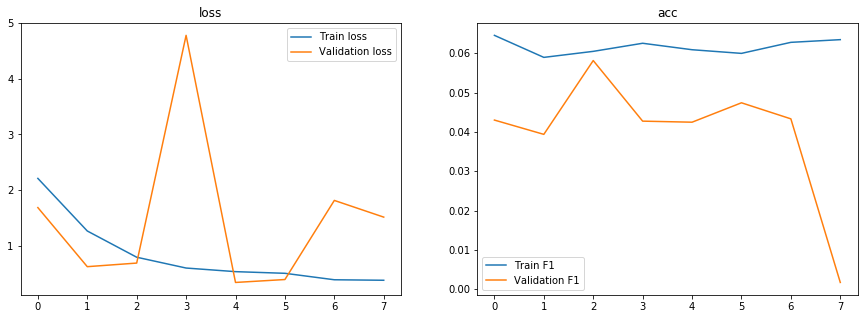

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(hist.epoch, hist.history["f1"], label="Train F1")
ax[1].plot(hist.epoch, hist.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

In [12]:
"""
# fine-tuning

for layer in model.layers:
    layer.trainable = False
    
model.layers[-1].trainable = True
model.layers[-2].trainable = True
model.layers[-3].trainable = True
model.layers[-4].trainable = True
model.layers[-5].trainable = True
model.layers[-6].trainable = True
model.layers[-7].trainable = True

model.compile(loss=f1_loss,
            optimizer=Adam(lr=1e-4),
            metrics=['accuracy', f1])

model.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    validation_steps=8,
    epochs=1,
    use_multiprocessing=use_multiprocessing, # you have to train the model on GPU in order to this to be benefitial
    workers=workers, # you have to train the model on GPU in order to this to be benefitial
    verbose=1,
    max_queue_size=4
)
"""

"\n# fine-tuning\n\nfor layer in model.layers:\n    layer.trainable = False\n    \nmodel.layers[-1].trainable = True\nmodel.layers[-2].trainable = True\nmodel.layers[-3].trainable = True\nmodel.layers[-4].trainable = True\nmodel.layers[-5].trainable = True\nmodel.layers[-6].trainable = True\nmodel.layers[-7].trainable = True\n\nmodel.compile(loss=f1_loss,\n            optimizer=Adam(lr=1e-4),\n            metrics=['accuracy', f1])\n\nmodel.fit_generator(\n    tg,\n    steps_per_epoch=len(tg),\n    validation_data=vg,\n    validation_steps=8,\n    epochs=1,\n    use_multiprocessing=use_multiprocessing, # you have to train the model on GPU in order to this to be benefitial\n    workers=workers, # you have to train the model on GPU in order to this to be benefitial\n    verbose=1,\n    max_queue_size=4\n)\n"

In [13]:
bestModel = load_model('./base.model', custom_objects={'f1': f1,'selu':selu}) #, 'f1_loss': f1_loss})
#bestModel = model

In [14]:
fullValGen = vg

In [15]:
from sklearn.metrics import f1_score as off1

def getOptimalT(mdl, fullValGen):
    
    lastFullValPred = np.empty((0, 28))
    lastFullValLabels = np.empty((0, 28))
    for i in tqdm(range(len(fullValGen))): 
        im, lbl = fullValGen[i]
        scores = mdl.predict(im)
        lastFullValPred = np.append(lastFullValPred, scores, axis=0)
        lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
    print(lastFullValPred.shape, lastFullValLabels.shape)
    
    rng = np.arange(0, 1, 0.001)
    f1s = np.zeros((rng.shape[0], 28))
    for j,t in enumerate(tqdm(rng)):
        for i in range(28):
            p = np.array(lastFullValPred[:,i]>t, dtype=np.int8)
            #scoref1 = K.eval(f1_score(fullValLabels[:,i], p, average='binary'))
            scoref1 = off1(lastFullValLabels[:,i], p, average='binary')
            f1s[j,i] = scoref1
            
    print(np.max(f1s, axis=0))
    print(np.mean(np.max(f1s, axis=0)))
    
    plt.plot(rng, f1s)
    T = np.empty(28)
    for i in range(28):
        T[i] = rng[np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0]]
    #print('Choosing threshold: ', T, ', validation F1-score: ', max(f1s))
    print(T)
    
    return T, np.mean(np.max(f1s, axis=0))

Last model after fine-tuning


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [01:09<00:00,  1.41s/it]


(3108, 28) (3108, 28)


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.98it/s]


[0.58375378 0.08148148 0.20606061 0.08973571 0.11579266 0.16040249
 0.05141066 0.17015013 0.00577478 0.00192864 0.00128617 0.0755418
 0.04773869 0.02666667 0.067765   0.00128617 0.03539823 0.01024328
 0.05628518 0.10198473 0.00513479 0.23459245 0.05506884 0.17552099
 0.01785714 0.40982348 0.02415766 0.        ]
0.10045865036913137
[0.015 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


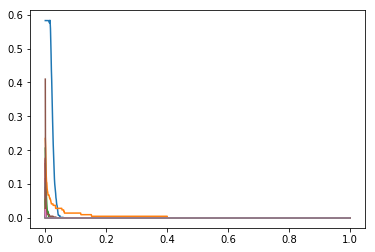

In [16]:
fullValGen = ProteinDataGenerator(paths[lastTrainIndex:], labels[lastTrainIndex:], BATCH_SIZE, SHAPE)
print('Last model after fine-tuning')
T1, ff1 = getOptimalT(model, fullValGen)

Best save model


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [01:09<00:00,  1.42s/it]


(3108, 28) (3108, 28)


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.39it/s]


[0.58325624 0.08148148 0.20612009 0.08973571 0.11579266 0.16740088
 0.0777027  0.17025037 0.00577478 0.00192864 0.00128617 0.07604064
 0.04773869 0.02666667 0.1453958  0.00169205 0.03596127 0.01024328
 0.05882353 0.10328339 0.00533867 0.31219512 0.05506884 0.18368121
 0.01785714 0.47345133 0.02415766 0.        ]
0.10994017993219654
[0.498 0.    0.038 0.    0.    0.046 0.003 0.019 0.    0.    0.    0.015
 0.    0.    0.003 0.001 0.014 0.    0.022 0.013 0.007 0.153 0.    0.066
 0.    0.25  0.    0.   ]


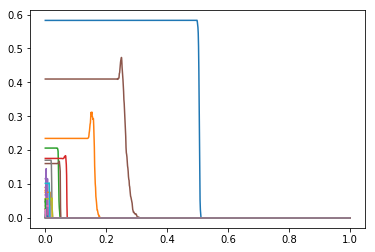

In [17]:
print('Best save model')
T2, ff2 = getOptimalT(bestModel, fullValGen)

In [18]:
if ff1 > ff2:
    T = T1
    bestModel = model
else:
    T = T2
    bestModel = bestModel

In [ ]:
pathsTest, labelsTest = getTestDataset()

testg = ProteinDataGenerator(pathsTest, labelsTest, BATCH_SIZE, SHAPE)
submit = pd.read_csv(DIR + '/sample_submission.csv')
P = np.zeros((pathsTest.shape[0], 28))
for i in tqdm(range(len(testg))):
    images, labels = testg[i]
    score = bestModel.predict(images)
    P[i*BATCH_SIZE:i*BATCH_SIZE+score.shape[0]] = score

 13%|██████████▎                                                                    | 24/183 [25:14<2:47:10, 63.09s/it]

In [ ]:
PP = np.array(P)

prediction = []

for row in tqdm(range(submit.shape[0])):
    
    str_label = ''
    
    for col in range(PP.shape[1]):
        if(PP[row, col] < T[col]):
            str_label += ''
        else:
            str_label += str(col) + ' '
    prediction.append(str_label.strip())
    
submit['Predicted'] = np.array(prediction)
submit.to_csv('4channels_cnn_from_scratch.csv', index=False)